# Statistical Analysis
In this section, I will ***

Lets load our cleaned and explored data set:

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import statsmodels.api as sm
from sklearn.metrics import classification_report

In [2]:
#####

# File 1 - Board Games

# Load the CSV file
df1 = pd.read_csv('Boardgames_SQL_Cleaned_File.csv') 

# Create new column "Adjusted Release year"
df1['Adjusted Release Year'] = df1['Release Year'].apply(lambda x: 2001 if x < 2001 else x)

# Calculate the number of years since the games adjusted release year
df1['Years Since Release'] = 2024 - df1['Adjusted Release Year']
df1['Years Since Release'] = df1['Years Since Release'].replace(0,1)

# Calculate votes per year rounded to nearest whole number
df1['Votes per Adjusted Release Year'] = df1['Voters'] / df1['Years Since Release']
df1['Votes per Adjusted Release Year'] = df1['Votes per Adjusted Release Year'].round(0).astype(int)

# Calculate the standard deviation on Votes per Adjusted Release Year and apply it as a weighting column
mean_votes = df1['Votes per Adjusted Release Year'].mean()
std_dev_votes = df1['Votes per Adjusted Release Year'].std(ddof=0)
df1['SDs from Mean'] = (df1['Votes per Adjusted Release Year'] - mean_votes) / std_dev_votes
df1['SD Weight'] = 1 / ((df1['SDs from Mean'].abs() + 1))
df1['Weighted Result'] = df1['Votes per Adjusted Release Year'] * df1['SD Weight']
df1['Weighted Result'] = df1['Weighted Result'].round(2)

# Normalised results on a scale of -1 to 1 and name it Popularity
min_sd = df1['Weighted Result'].min()
max_sd = df1['Weighted Result'].max()
df1['Popularity'] = 2 * ((df1['Weighted Result'] - min_sd) / (max_sd - min_sd)) - 1
df1['Popularity'] = df1['Popularity'].round(2)

# Normalised Geek Rating on a scale of -1 to 1 and name it Quality
min_sd = df1['Geek Rating'].min()
max_sd = df1['Geek Rating'].max()
df1['Quality'] = 2 * ((df1['Geek Rating'] - min_sd) / (max_sd - min_sd)) - 1
df1['Quality'] = df1['Quality'].round(2)

# Add a column called score
df1['Score'] = df1['Popularity'] + df1['Quality']

# Add a column called 'Great Game' which shows True or False based on Quality and Popularity >= 0.4
df1['Great Game'] = (df1['Quality'] >= 0.4) & (df1['Popularity'] >= 0.4)

#####

# File 2 - Board Game Info

# Load the CSV file
df2 = pd.read_csv('Boardgame_Info_Cleaned_File.csv') 

# Fields to winsorize
columns_to_winsorize = ['Price', 'Max players', 'Min time (mins)', 'Max time (mins)']

# Calculate 99th percentile and Clip and cap the values
for col in columns_to_winsorize:
    upper_cap = df2[col].quantile(0.99)
    df2[col] = df2[col].clip(upper=upper_cap)
    df2[col] = df2[col].apply(lambda x: upper_cap if x > upper_cap else x)

# Add a new column for average playtime
df2['Average playtime (mins)'] = (df2['Min time (mins)'] + df2['Max time (mins)']) / 2

# Get the unique types from both columns
unique_types = pd.unique(df2[['Type 1', 'Type 2']].values.ravel('K'))

# Create columns for each unique type and set the category
for type in unique_types:
    df2[type] = ((df2['Type 1'] == type) | (df2['Type 2'] == type)).astype(int)

#####

# File 3 - Local Store Info

# Load the CSV file
df3 = pd.read_csv('My_Local_BG_Store_Cleaned_File.csv') 

#####

# Merge Board Games with Board Game Info on Title
df1['Title'] = df1['Title'].str.strip()
df2['Title'] = df2['Title'].str.strip()
merged_df1 = pd.merge(df1, df2, on='Title', how='inner')

# Create a new column 'Local Store' in merged_df1 with 1 if the title is in df3 and 0 if not
merged_df1['Local Store'] = merged_df1['Title'].apply(lambda x: 1 if x in df3['Title'].values else 0)

#####

# File 4 - Review Counts

# Load the CSV file
df4 = pd.read_csv('Boardgames_Reviews_SQL_Cleaned_File.csv') 

# Create the new column 'First Year Review Count'
df4['First Year Review Count'] = df4.apply(lambda row: row[str(row['Adjusted Release Year'] + 1)], axis=1)

#####

# Add early review count column to merged file
merged_df1 = merged_df1.merge(df4[['Game ID', 'First Year Review Count']], on='Game ID', how='left')

#####

# Use panda NULL
merged_df1.replace('',pd.NA, inplace=True)

# Handling NULL values by replacing them with the mean
for column in merged_df1.select_dtypes(include=['number']).columns:
    merged_df1[column].fillna(merged_df1[column].mean(), inplace=True)

# Show the top 10 rows
merged_df1.head(10)

,Rank,Game ID,Title,Description,Release Year,Geek Rating,Avg Rating,Voters,Adjusted Release Year,Years Since Release,...,Thematic,Family,Customizable,Abstract,Party,Wargames,Children's,NaN,Local Store,First Year Review Count
0,1,224517,Brass: Birmingham,"Build networks, grow industries, and navigate ...",2018,8.407,8.58,50109,2018,6,...,0,0,0,0,0,0,0,0,0,4601.000000
1,2,161936,Pandemic Legacy: Season 1,Mutating diseases are spreading around the wor...,2015,8.370,8.52,54954,2015,9,...,1,0,0,0,0,0,0,0,0,7597.000000
2,3,342942,Ark Nova,"Plan and build a modern, scientifically manage...",2021,8.342,8.53,49624,2021,3,...,0,0,0,0,0,0,0,0,1,102.713525
3,4,174430,Gloomhaven,Vanquish monsters with strategic cardplay. Ful...,2017,8.335,8.57,64071,2017,7,...,1,0,0,0,0,0,0,0,0,9610.000000
4,5,233078,Twilight Imperium: Fourth Edition,"Build an intergalactic empire through trade, r...",2017,8.232,8.58,25359,2017,7,...,1,0,0,0,0,0,0,0,0,2837.000000
5,6,316554,Dune: Imperium,"Influence, intrigue, and combat in the univers...",2020,8.228,8.43,50373,2020,4,...,0,0,0,0,0,0,0,0,1,102.713525
6,7,167791,Terraforming Mars,Compete with rival CEOs to make Mars habitable...,2016,8.204,8.35,104081,2016,8,...,0,0,0,0,0,0,0,0,1,9866.000000
7,8,115746,War of the Ring: Second Edition,The Fellowship and the Free Peoples clash with...,2011,8.192,8.55,22685,2011,13,...,1,0,0,0,0,1,0,0,0,336.000000
8,9,187645,Star Wars: Rebellion,Strike from your hidden base as the Rebels—or ...,2016,8.169,8.42,33850,2016,8,...,1,0,0,0,0,0,0,0,0,4707.000000
9,10,162886,Spirit Island,Island Spirits join forces using elemental pow...,2017,8.144,8.34,55560,2017,7,...,0,0,0,0,0,0,0,0,1,4396.000000


## Check the data:

In [3]:
merged_df1.shape
merged_df1.info()
merged_df1.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24969 entries, 0 to 24968
Data columns (total 39 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Rank                             24969 non-null  int64  
 1   Game ID                          24969 non-null  int64  
 2   Title                            24969 non-null  object 
 3   Description                      13481 non-null  object 
 4   Release Year                     24969 non-null  int64  
 5   Geek Rating                      24969 non-null  float64
 6   Avg Rating                       24969 non-null  float64
 7   Voters                           24969 non-null  int64  
 8   Adjusted Release Year            24969 non-null  int64  
 9   Years Since Release              24969 non-null  int64  
 10  Votes per Adjusted Release Year  24969 non-null  int64  
 11  SDs from Mean                    24969 non-null  float64
 12  SD Weight         

,Rank,Game ID,Release Year,Geek Rating,Avg Rating,Voters,Adjusted Release Year,Years Since Release,Votes per Adjusted Release Year,SDs from Mean,...,Thematic,Family,Customizable,Abstract,Party,Wargames,Children's,NaN,Local Store,First Year Review Count
count,24969.000000,24969.000000,24969.000000,24969.000000,24969.000000,24969.000000,24969.000000,24969.000000,24969.000000,24969.000000,...,24969.000000,24969.000000,24969.000000,24969.000000,24969.000000,24969.000000,24969.000000,24969.0,24969.000000,24969.000000
mean,13569.037406,141285.073932,2006.927670,5.688095,6.429900,1069.958348,2011.461012,12.538988,148.515119,0.010389,...,0.064600,0.124314,0.013577,0.055669,0.033642,0.163923,0.039008,0.0,0.018623,102.713525
std,8212.740143,121545.946315,35.798081,0.363171,0.888691,4554.157983,7.527665,7.527665,612.654261,1.023603,...,0.245824,0.329946,0.115728,0.229286,0.180309,0.370213,0.193619,0.0,0.135192,399.944894
min,1.000000,1.000000,400.000000,4.554000,1.270000,30.000000,2001.000000,1.000000,1.000000,-0.236075,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,6316.000000,15542.000000,2003.000000,5.509000,5.870000,63.000000,2003.000000,6.000000,5.000000,-0.229392,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,3.000000
50%,13201.000000,137841.000000,2013.000000,5.543000,6.470000,146.000000,2013.000000,11.000000,16.000000,-0.211013,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,18.000000
75%,20901.000000,244654.000000,2018.000000,5.679000,7.030000,482.000000,2018.000000,21.000000,64.000000,-0.130816,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,102.713525
max,27891.000000,404268.000000,2023.000000,8.407000,9.460000,132623.000000,2023.000000,23.000000,20046.000000,33.254458,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,16683.000000


## Feature Selection
When selecting features, I needed to be careful not to select any that "give away the ending". For example, I made sure to remove:
- Popularity
- Quality
- Score
- Geek Rating
- Voters
- Avg Rating

These features are directly, (or closely) used in how we calculate what a "Great Game" is, and we will not necessarily know this information in a games early stages to be able to predict if a game is going to be successful. 

The remaining fields:
- First Year Review Count
- Average playtime (mins)
- Complexity
- Price
- Max players
- Age Rating
- Local Store
- Adjusted Release Year
- Min players
- Strategy
- Thematic
- Family
- Customizable
- Abstract
- Party
- Wargames
- Children's

Can all be used to help us predict, based on a games first year of release, is it going to take off into the realms of the greats.

In [4]:

# Define features
features = ['First Year Review Count', 'Average playtime (mins)', 'Complexity', 'Price', 'Max players', 'Age Rating', 'Local Store', 'Adjusted Release Year', 'Min players', 'Strategy', 'Thematic', 'Family', 'Customizable', 'Abstract', 'Party', 'Wargames', 'Children\'s']

X = merged_df1[features]
y = merged_df1['Great Game']

#Split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (17478, 17)
X_test shape: (7491, 17)
y_train shape: (17478,)
y_test shape: (7491,)


In [5]:
#Check proportion of contact received split
print("Training set target distribution:\n", y_train.value_counts(normalize=True))
print("Test set target distribution:\n", y_test.value_counts(normalize=True))

Training set target distribution:
 Great Game
False    0.985067
True     0.014933
Name: proportion, dtype: float64
Test set target distribution:
 Great Game
False    0.984915
True     0.015085
Name: proportion, dtype: float64


In [6]:
#What is the Y variable
print("\nTarget (y):")
print(y.head())


Target (y):
0    True
1    True
2    True
3    True
4    True
Name: Great Game, dtype: bool


In [7]:
#What are the x variables
print("Features (X):")
print(X.head())

Features (X):
   First Year Review Count  Average playtime (mins)  Complexity       Price  \
0              4601.000000                     90.0        3.89   84.990000   
1              7597.000000                     60.0        2.83   49.970000   
2               102.713525                    120.0        3.74   58.990000   
3              9610.000000                     90.0        3.90   50.738236   
4              2837.000000                    360.0        4.31  126.490000   

   Max players  Age Rating  Local Store  Adjusted Release Year  Min players  \
0          4.0        14.0            0                   2018          2.0   
1          4.0        13.0            0                   2015          2.0   
2          4.0        14.0            1                   2021          1.0   
3          4.0        14.0            0                   2017          1.0   
4          6.0        14.0            0                   2017          3.0   

   Strategy  Thematic  Family  Custo

In [8]:
#Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
#Build the model
model = LogisticRegression()

In [10]:
# Initialize RFE with the model and the number of features to select
rfe = RFE(model, n_features_to_select=17)

# Fit RFE to the training data
rfe.fit(X_train_scaled, y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=17)

In [11]:
# Get the selected features
selected_features = rfe.support_

# Get the ranking of features
feature_ranking = rfe.ranking_

print("Selected Features:", selected_features)
print("Feature Ranking:", feature_ranking)

Selected Features: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
Feature Ranking: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [12]:
#Only include selected features
X_train_rfe = rfe.transform(X_train_scaled)
X_test_rfe = rfe.transform(X_test_scaled)

In [13]:
#Train the model
model.fit(X_train_rfe, y_train)

# Evaluate the model
y_pred = model.predict(X_test_rfe)

In [14]:
#Evaluate the model

# Generate the classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Convert the report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Format the DataFrame
report_df['precision'] = (report_df['precision'] * 100).round(2).astype(str) + '%'
report_df['recall'] = (report_df['recall'] * 100).round(2).astype(str) + '%'
report_df['f1-score'] = (report_df['f1-score'] * 100).round(2).astype(str) + '%'
report_df['support'] = report_df['support'].astype(int)

# Display the formatted DataFrame
print(report_df)

             precision  recall f1-score  support
False           99.06%  99.85%   99.45%     7378
True            79.63%  38.05%    51.5%      113
accuracy        98.92%  98.92%   98.92%        0
macro avg       89.34%  68.95%   75.48%     7491
weighted avg    98.77%  98.92%   98.73%     7491


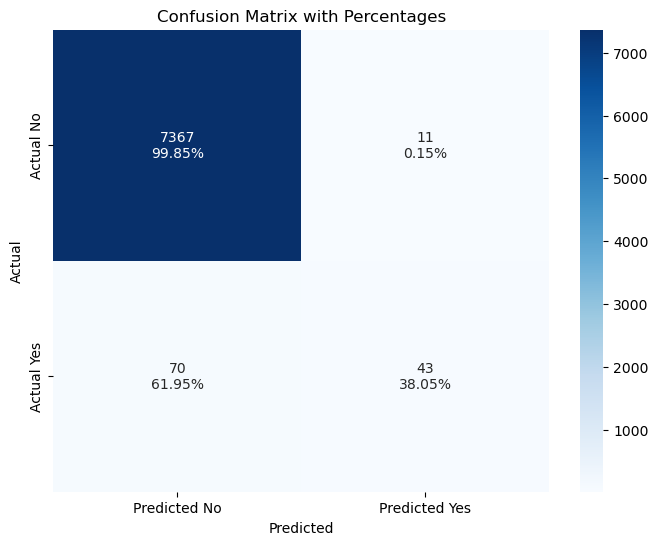

In [15]:
#Confusion Matrix

# Assuming y_test and y_pred are your true labels and predictions
cm = confusion_matrix(y_test, y_pred)

# Calculate the percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a combined matrix with counts and percentages
labels = np.array([f'{count}\n{percentage:.2%}' for count, percentage in zip(cm.flatten(), cm_percentage.flatten())]).reshape(2, 2)

# Plot the confusion matrix with the new labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Percentages')
plt.show()

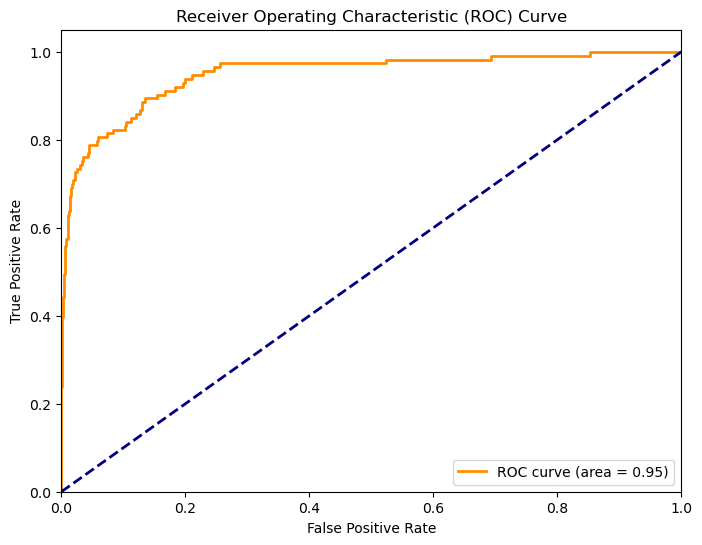

In [16]:
#ROC Curve

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_rfe)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

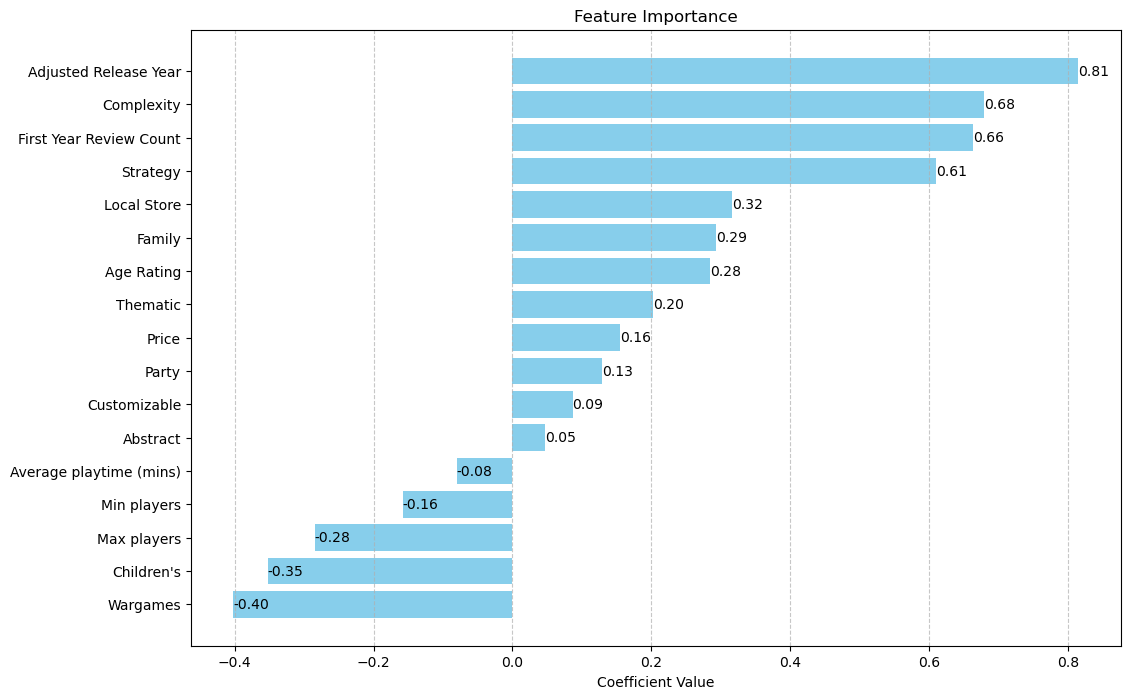

In [17]:
# Get the selected features
selected_features = rfe.support_

# Get the ranking of features
feature_ranking = rfe.ranking_

feature_names = ['First Year Review Count', 'Average playtime (mins)', 'Complexity', 'Price', 'Max players', 'Age Rating', 'Local Store', 'Adjusted Release Year', 'Min players', 'Strategy', 'Thematic', 'Family', 'Customizable', 'Abstract', 'Party', 'Wargames', 'Children\'s']

# Convert X_train_scaled to DataFrame
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
selected_feature_names = X_train_df.columns[selected_features]
X_train_selected = X_train_df.iloc[:, selected_features]

# Convert X_test_scaled to DataFrame
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)
X_test_selected = X_test_df.iloc[:, selected_features]

# Assuming model is your trained logistic regression model
model = LogisticRegression()
model.fit(X_train_selected, y_train)

# Feature Importance
coefficients = model.coef_[0]
features = selected_feature_names

# Sort features by importance
sorted_indices = np.argsort(coefficients)
features = np.array(features)[sorted_indices]
coefficients = np.array(coefficients)[sorted_indices]

# Create a bar plot
plt.figure(figsize=(12, 8))
bars = plt.barh(np.arange(len(features)), coefficients, align='center', color='skyblue')
plt.yticks(np.arange(len(features)), features)
plt.xlabel('Coefficient Value')
plt.title('Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add annotations
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', 
             ha='left', va='center', color='black')

plt.show()

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


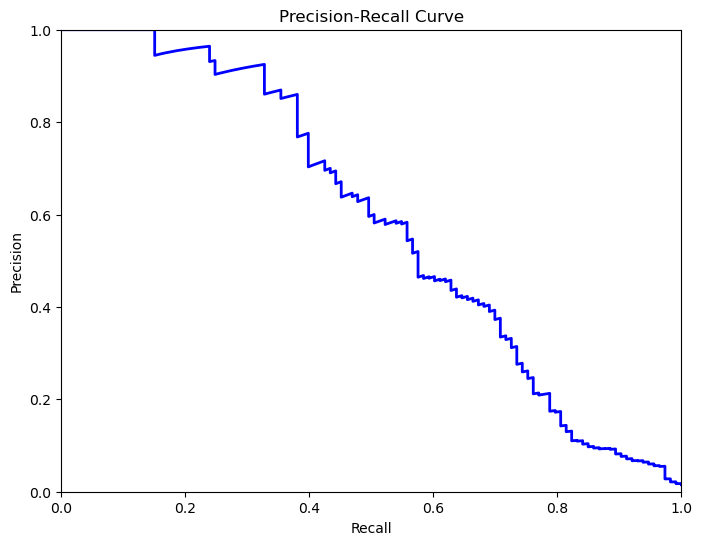

In [18]:
#Precision Recall Curve
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test_rfe)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()

In [19]:
# Get the selected features
selected_features = rfe.support_

# Get the ranking of features
feature_ranking = rfe.ranking_

# Filter the dataset to include only the selected features
selected_feature_names = X_train.columns[selected_features]
X_train_selected = X_train_scaled[:, selected_features]
X_test_selected = X_test_scaled[:, selected_features]

# Fit the model with the selected features
model = sm.GLM(y_train, sm.add_constant(X_train_selected), family=sm.families.Binomial())
results = model.fit()

# Coefficients
coeff_df = pd.DataFrame(zip(selected_feature_names, results.params[1:]))
coeff_df.columns = ["feature", "coefficient"]
coeff_df

,feature,coefficient
0,First Year Review Count,0.664645
1,Average playtime (mins),-0.083868
2,Complexity,0.687568
3,Price,0.155129
4,Max players,-0.300333
5,Age Rating,0.283349
6,Local Store,0.317097
7,Adjusted Release Year,0.829084
8,Min players,-0.154563
9,Strategy,0.610973


In [20]:
#Exponent
coeff_df['exp'] = np.exp(coeff_df['coefficient'])
coeff_df

,feature,coefficient,exp
0,First Year Review Count,0.664645,1.943801
1,Average playtime (mins),-0.083868,0.919553
2,Complexity,0.687568,1.988873
3,Price,0.155129,1.167808
4,Max players,-0.300333,0.740571
5,Age Rating,0.283349,1.327568
6,Local Store,0.317097,1.373136
7,Adjusted Release Year,0.829084,2.291219
8,Min players,-0.154563,0.856790
9,Strategy,0.610973,1.842222
